## Метод SVD-DFA (краткое описание)

**SVD-DFA (Singular Value Decomposition – Detrended Fluctuation Analysis)** —
это модификация классического DFA, предназначенная для более устойчивой
оценки масштабных корреляций и показателя Херста H в нестационарных
временных рядах с трендами и гармоническими компонентами.

Идея метода состоит в том, чтобы **перед DFA удалить детерминированные
компоненты** сигнала с помощью сингулярного разложения (SVD), что снижает
риск ложных степенных зависимостей и переоценки H.

---

### Шаг 1. Интегральный профиль

Для временного ряда x(t), t = 1, ..., N, строится интегральный профиль:

$$
y(t) = \sum_{i=1}^{t} \bigl(x(i) - \bar{x}\bigr),
$$

---

### Шаг 2. SVD-фильтрация профиля

1. Из профиля y(t) формируется траекторная (Hankel) матрица с окном L:

$$
\mathbf{Y} =
\begin{pmatrix}
y(1)   & y(2)   & \dots  & y(K) \\
y(2)   & y(3)   & \dots  & y(K+1) \\
\vdots & \vdots & \ddots & \vdots \\
y(L)   & y(L+1)& \dots  & y(N)
\end{pmatrix},
\qquad L \approx \frac{N}{3}.
$$

2. Выполняется сингулярное разложение:

$$
\mathbf{Y} = \mathbf{U}\,\mathbf{\Sigma}\,\mathbf{V}^{\mathsf{T}}.
$$

3. Первые p (обычно p = 1–3) наибольших сингулярных значений зануляются,
что соответствует удалению гладких трендов и периодических компонент.

4. Очищенный профиль \tilde{y}(t) восстанавливается диагональным
усреднением (Hankelization).

---

### Шаг 3. DFA для очищенного профиля

Для каждого масштаба n профиль \tilde{y}(t) разбивается на сегменты длины n.
В каждом сегменте локальный тренд аппроксимируется полиномом порядка m,
после чего вычисляется флуктуационная функция:

$$
F^2(n) =
\frac{1}{N}
\sum_{t=1}^{N} \bigl[\,\tilde{y}(t) - y_{n}^{(\mathrm{fit})}(t)\,\bigr]^2.
$$

---

### Шаг 4. Масштабный закон

Если выполняется степенная зависимость

$$
F(n) \sim n^{H},
$$

то показатель Херста H определяется как наклон зависимости log F(n) от log n.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from StatTools.generators.kasdin_generator import create_kasdin_generator
from StatTools.analysis.svd_dfa import svd_dfa
from dataclasses import dataclass
from StatTools.analysis.dfa import DFA
from dataclasses import asdict



### Генерация fGn/fBm и оценка показателя Херста

В данном фрагменте кода реализованы вспомогательные функции для генерации
фрактальных временных рядов и оценки показателя Херста на основе
масштабной зависимости флуктуаций.

Функция `fgn_spectral` генерирует **фрактальный гауссов шум (fGn)** с заданным
показателем Херста H в диапазоне (0, 1) и длиной ряда N. Генерация выполняется
спектральным методом (алгоритм Касдина), обеспечивающим корректную
корреляционную структуру шума для выбранного значения H.

Функция `fbm_from_fgn` строит **фрактальное броуновское движение (fBm)** путём
интегрирования fGn: последовательное суммирование приращений переводит
стационарный fGn в нестационарный fBm с тем же показателем Херста.

Функция `estimate_hurst_from_loglog` предназначена для оценки показателя
Херста по результатам DFA или SVD-DFA. Предполагается, что флуктуационная
функция подчиняется степенному закону:

$$
F(n) \sim n^{H}.
$$

Тогда оценка H производится как наклон линейной регрессии в логарифмических
координатах: выполняется аппроксимация зависимости log(F(n)) от log(n)
методом наименьших квадратов, а искомое значение H берётся как коэффициент
наклона (slope) этой прямой.


In [2]:
def fgn_spectral(H: float, N: int, rng: np.random.Generator | None = None) -> np.ndarray:
    return create_kasdin_generator(H, length=N).get_full_sequence()


def fbm_from_fgn(fgn: np.ndarray) -> np.ndarray:
    return np.cumsum(fgn)


def estimate_hurst_from_loglog(F: np.ndarray, s: np.ndarray) -> float:
    "Slope of log-log regression: log F(n) ~ H log n."
    x = np.log(s)
    y = np.log(F)
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(slope)

## Анализ логарифмических графиков `log F(n)` vs `log n` и влияние параметров SVD

1. Генерируем один сигнал (fGn и fBm).
2. Считаем `F(n)` в широком диапазоне масштабов.
3. Строим `log F(n)` от `log n`.
4. Сравниваем несколько `p` (число удаляемых сингулярных компонент).

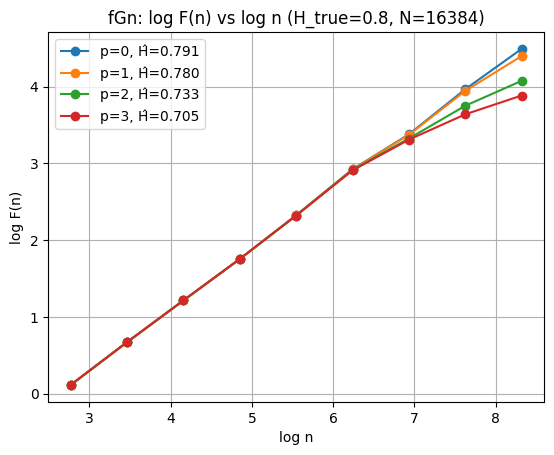

In [3]:
rng = np.random.default_rng(42)

H_true = 0.8
N = 2**14
scales = np.array([2**i for i in range(3, 20)])

x_fgn = fgn_spectral(H_true, N, rng=rng)

ps = [0, 1, 2, 3]

def plot_loglog_curves(signal: np.ndarray, integrate: bool, title: str):
    plt.figure()
    for p in ps:
        F, s = svd_dfa(signal, s=scales, integrate=integrate, p=p, m=1, L=None, n_min=10, n_max=N//4)
        plt.plot(np.log(s), np.log(F), marker="o", linestyle="-",
                 label=f"p={p}, Ĥ={estimate_hurst_from_loglog(F,s):.3f}")
    plt.xlabel("log n")
    plt.ylabel("log F(n)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loglog_curves(x_fgn, integrate=True,  title=f"fGn: log F(n) vs log n (H_true={H_true}, N={N})")

## n запусков при разных H, N, p: сводные графики и статистика

Делаем серию запусков:
- `H ∈ {0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2}`
- `N ∈ {2^8, 2^10, 2^12,, 2^13}`
- `p ∈ {0,1,2,3}`
- `n_runs = 10` повторов для каждой комбинации

Сводные графики: `Ĥ` vs `H` с error bars (±1σ).

In [4]:
# Hs = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2]
Hs = [0.1, 0.2, 0.4, 1.0, 1.2] # for local
Ns = [2**8, 2**10] # for local
# Ns = [2**8, 2**10, 2**12, 2**13]
Ps = [0, 1, 2, 3]
n_runs = 10

In [5]:
@dataclass
class Result:
    H_true: float
    N: int
    p: int
    rtype: str  # "fGn" or "fBm"
    H_hat: float


def run_experiment(n_runs: int = 10, seed: int = 123):
    rng = np.random.default_rng(seed)
    results = []
    for N in Ns:
        scales = np.array([2**i for i in range(3, 20)])

        for H in Hs:
            for _ in range(n_runs):
                fgn = fgn_spectral(H, N, rng=rng)
                fbm = fbm_from_fgn(fgn)

                # >>> DFA (custom) — fGn
                dfa_fgn = DFA(fgn)
                H_dfa_fgn = dfa_fgn.find_h()
                results.append(Result(H, N, -1, "fGn_DFA", H_dfa_fgn))


                for p in Ps:
                    Fg, sg = svd_dfa(fgn, s=scales, integrate=True,  p=p, m=1, L=None, n_min=10, n_max=N//4)
                    Hb_g = estimate_hurst_from_loglog(Fg, sg)
                    results.append(Result(H, N, p, "fGn", Hb_g))

                    Fg, sg = svd_dfa(fgn, s=scales, integrate=False,  p=p, m=1, L=None, n_min=10, n_max=N//4)
                    Hb_g = estimate_hurst_from_loglog(Fg, sg)
                    results.append(Result(H, N, p, "fGn without integrate", Hb_g))
            print("h " + str(H) + " n" + str(N))
    return results

results = run_experiment(n_runs=n_runs, seed=2025)
print("Total results:", len(results))

h 0.1 n256
h 0.2 n256


h 0.4 n256
h 1.0 n256


h 1.2 n256


h 0.1 n1024


h 0.2 n1024


h 0.4 n1024


h 1.0 n1024


h 1.2 n1024
Total results: 900


Смотрим как разные конфигурации влияют на результат

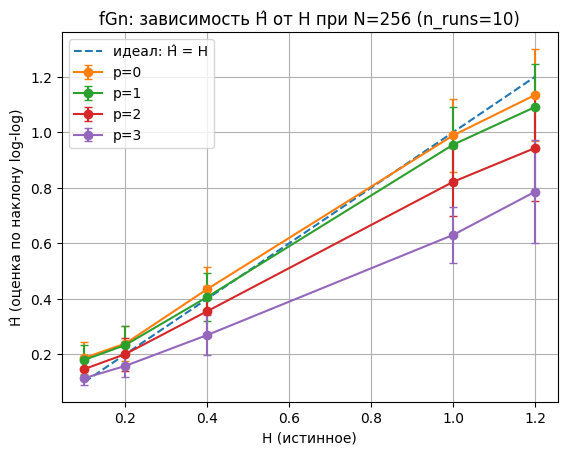

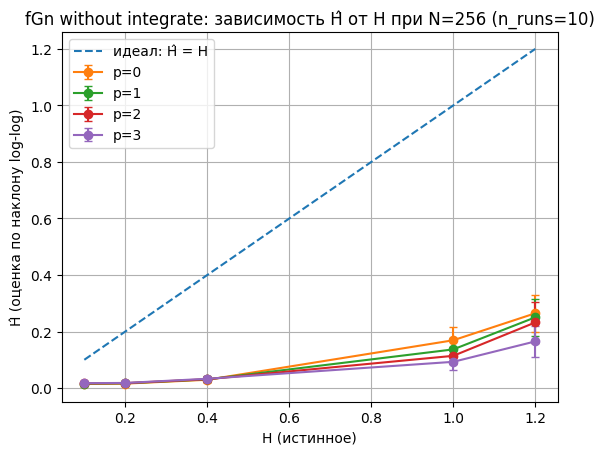

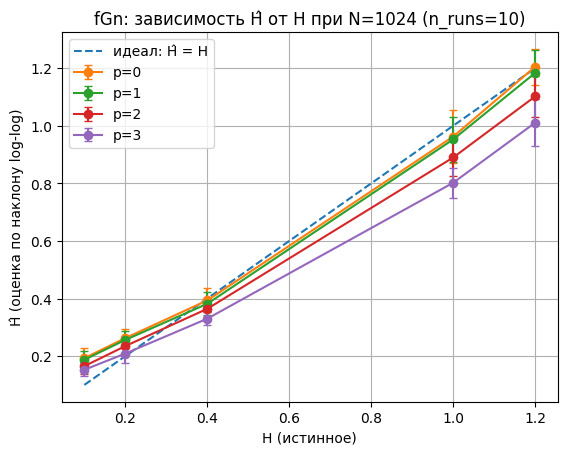

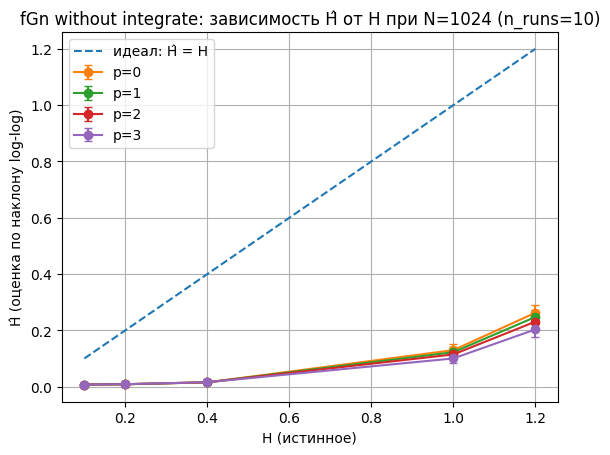

In [6]:
def summarize(results, rtype: str, N: int):
    out = {}
    for p in Ps:
        means = []
        stds = []
        for H in Hs:
            vals = [r.H_hat for r in results if r.rtype==rtype and r.N==N and r.p==p and abs(r.H_true-H)<1e-12]
            means.append(float(np.mean(vals)))
            stds.append(float(np.std(vals, ddof=1)) if len(vals)>1 else 0.0)
        out[p] = (np.array(Hs), np.array(means), np.array(stds))
    return out

def plot_summary(results, rtype: str, N: int):
    summ = summarize(results, rtype=rtype, N=N)
    plt.figure()
    plt.plot(Hs, Hs, linestyle="--", label="идеал: Ĥ = H")
    for p, (H_true_arr, mean_arr, std_arr) in summ.items():
        plt.errorbar(H_true_arr, mean_arr, yerr=std_arr, marker="o", linestyle="-",
                     capsize=3, label=f"p={p}")
    plt.xlabel("H (истинное)")
    plt.ylabel("Ĥ (оценка по наклону log-log)")
    plt.title(f"{rtype}: зависимость Ĥ от H при N={N} (n_runs={n_runs})")
    plt.grid(True)
    plt.legend()
    plt.show()

for N in Ns:
    plot_summary(results, rtype="fGn", N=N)
    plot_summary(results, rtype="fGn without integrate", N=N)

смотрим как разные конфигурации отклоняются от истинного

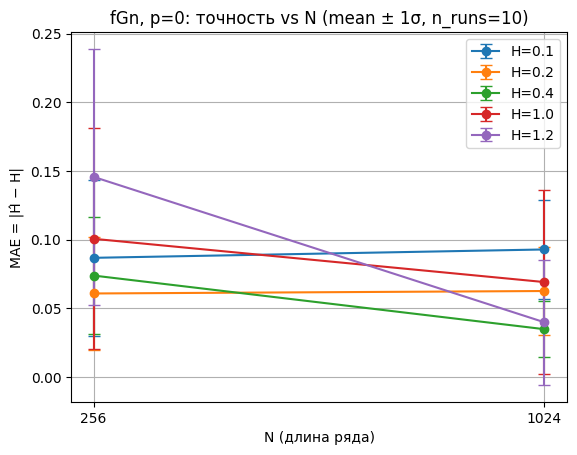

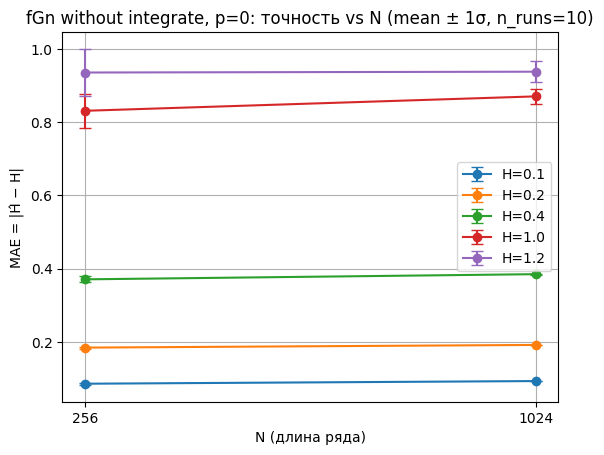

In [7]:
res_p0 = [r for r in results if r.p == 0]

def collect_stats(rtype: str):
    """
    Для каждого H и N считаем:
      mean(|H_hat - H|)
      std(|H_hat - H|)
    """
    stats = {}
    for H in Hs:
        xs = []
        mean_err = []
        std_err = []
        for N in Ns:
            vals = np.array(
                [r.H_hat for r in res_p0
                 if r.rtype == rtype and r.H_true == H and r.N == N],
                dtype=float
            )
            err = np.abs(vals - H)
            xs.append(N)
            mean_err.append(err.mean())
            std_err.append(err.std(ddof=1))
        stats[H] = (np.array(xs), np.array(mean_err), np.array(std_err))
    return stats


def plot_errorbar(rtype: str):
    stats = collect_stats(rtype)

    plt.figure()
    for H, (xs, mean_err, std_err) in stats.items():
        plt.errorbar(
            xs,
            mean_err,
            yerr=std_err,
            marker="o",
            linestyle="-",
            capsize=4,
            label=f"H={H}"
        )

    plt.xscale("log", base=2)
    plt.xticks(Ns, [str(N) for N in Ns])
    plt.xlabel("N (длина ряда)")
    plt.ylabel("MAE = |Ĥ − H|")
    plt.title(f"{rtype}, p=0: точность vs N (mean ± 1σ, n_runs={n_runs})")
    plt.grid(True)
    plt.legend()
    plt.show()


# --- графики
plot_errorbar("fGn")
plot_errorbar("fGn without integrate")


сраниваем шан метод с dfa

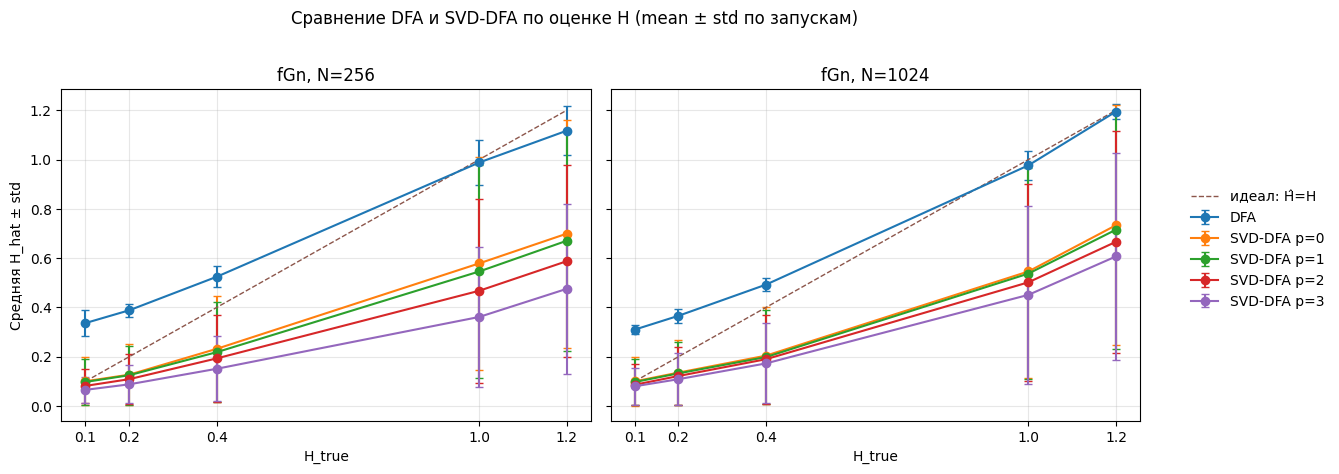

In [8]:
# 1) results -> DataFrame
df = pd.DataFrame([asdict(r) for r in results])

# 2) signal/method labels
def parse_signal(rtype: str) -> str:
    if rtype.startswith("fGn"):
        return "fGn"
    return rtype


df["signal"] = df["rtype"].apply(parse_signal)
df["method"] = np.where(df["rtype"].isin(["fGn_DFA"]), "DFA", "SVD-DFA")
df["label"]  = np.where(df["method"] == "DFA", "DFA", df["p"].map(lambda x: f"SVD-DFA p={int(x)}"))

# 3) агрегаты (mean±std по прогонам)
agg = (df.groupby(["signal", "N", "H_true", "label"], as_index=False)
       .agg(H_hat_mean=("H_hat","mean"), H_hat_std=("H_hat","std")))
Hs = sorted(agg["H_true"].unique())
Ns = sorted(agg["N"].unique())
signals = ["fGn"]

# 4) график: 2x|Ns| панелей, линии для DFA и каждого p
fig, axes = plt.subplots(len(signals), len(Ns),
                         figsize=(5.8*len(Ns), 4.6*len(signals)),
                         sharey=True)

# нормализация axes под любые размеры
axes = np.atleast_2d(axes)

for i, sig in enumerate(signals):
    for j, N in enumerate(Ns):
        ax = axes[i, j]
        sub = agg[(agg["signal"] == sig) & (agg["N"] == N)].copy()

        for label, g in sub.groupby("label"):
            g = g.sort_values("H_true")
            ax.errorbar(g["H_true"], g["H_hat_mean"], yerr=g["H_hat_std"],
                        marker="o", capsize=3, label=label)

        ax.plot(Hs, Hs, "--", linewidth=1, label="идеал: Ĥ=H")
        ax.set_title(f"{sig}, N={N}")
        ax.set_xlabel("H_true")
        if j == 0:
            ax.set_ylabel("Средняя H_hat ± std")
        ax.set_xticks(Hs)
        ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    frameon=False
)
fig.tight_layout(rect=[0, 0, 0.85, 1])

fig.suptitle("Сравнение DFA и SVD-DFA по оценке H (mean ± std по запускам)", y=1.02)
fig.tight_layout()
plt.show()


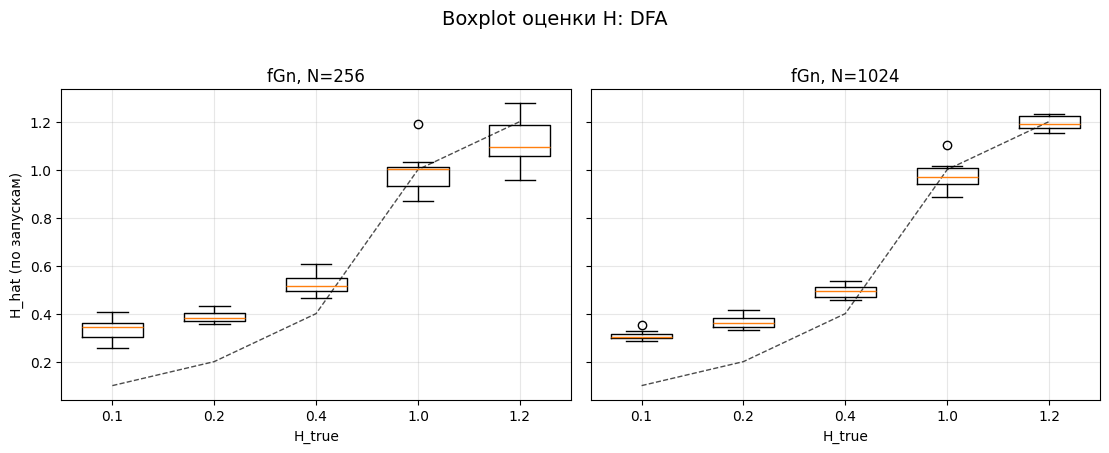

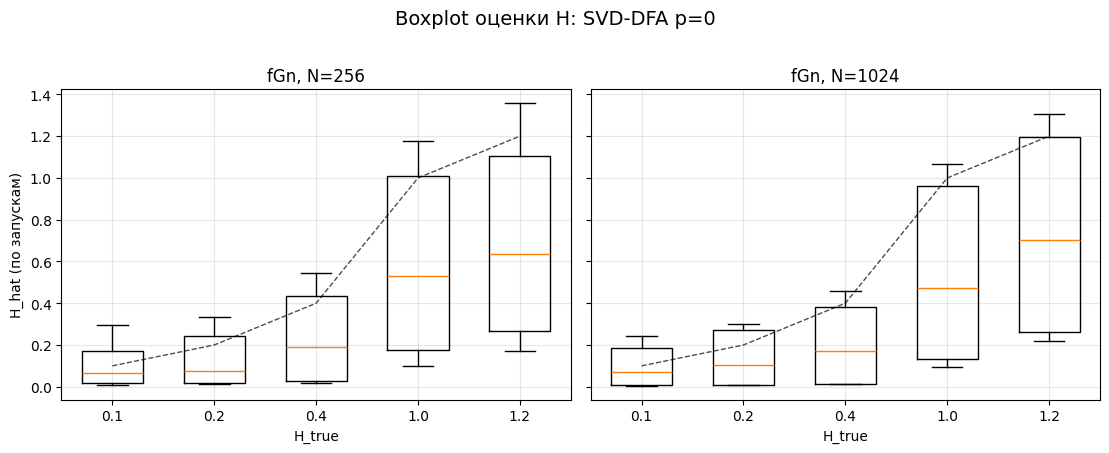

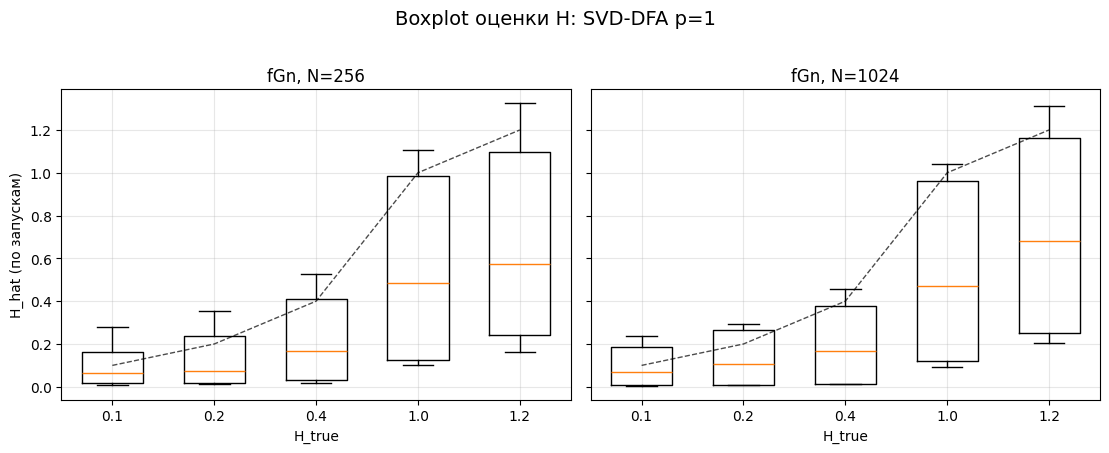

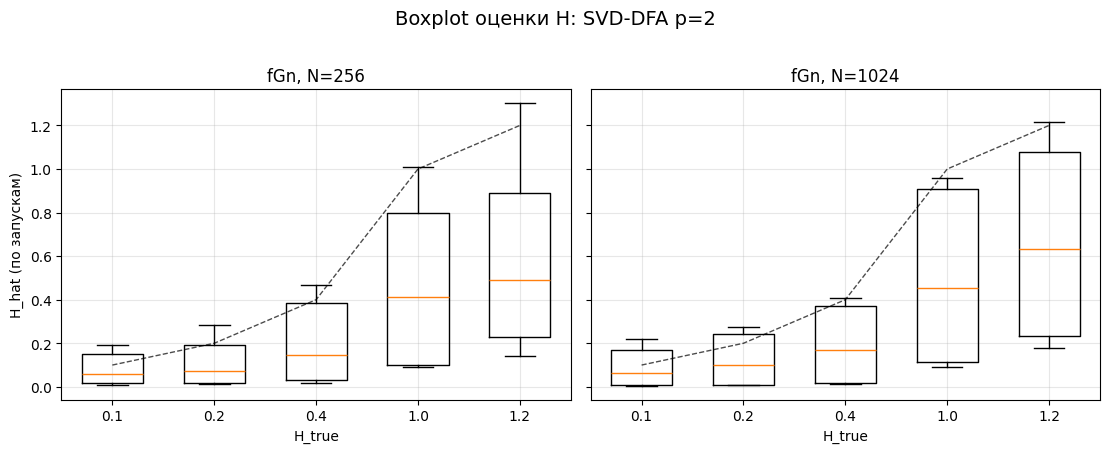

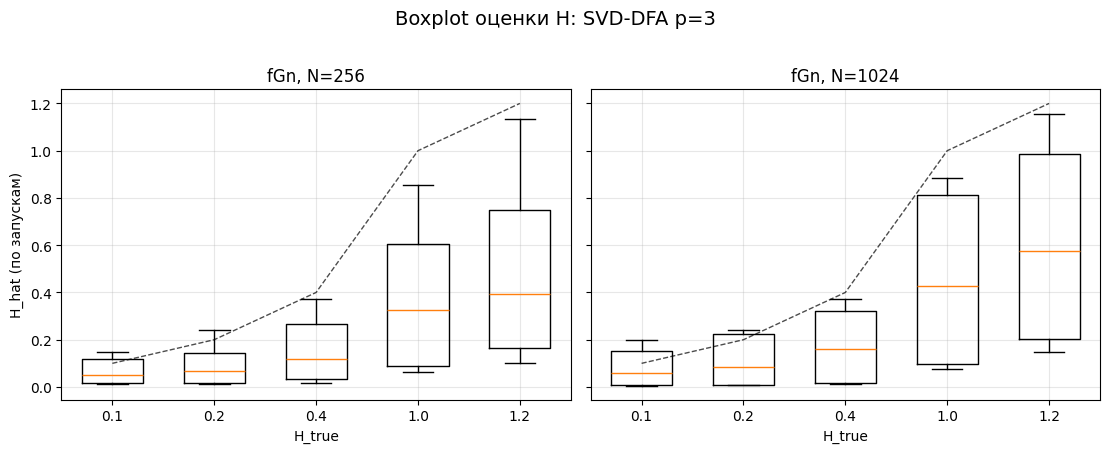

In [9]:
import numpy as np
import matplotlib.pyplot as plt

Hs = sorted(df["H_true"].unique())
Ns = sorted(df["N"].unique())
signals = ["fGn"]

def label_key(lab):
    if lab == "DFA":
        return (0, 0)
    p = int(str(lab).split("p=")[-1])
    return (1, p)

labels_all = sorted(df["label"].unique(), key=label_key)

for label in labels_all:

    fig, axes = plt.subplots(
        len(signals), len(Ns),
        figsize=(5.6 * len(Ns), 4.4 * len(signals)),
        sharey=True
    )
    axes = np.atleast_2d(axes)

    for i, sig in enumerate(signals):
        for j, N in enumerate(Ns):
            ax = axes[i, j]

            sub = df[
                (df["signal"] == sig) &
                (df["N"] == N) &
                (df["label"] == label)
                ]

            data = []
            for H in Hs:
                vals = sub[sub["H_true"] == H]["H_hat"].dropna().values
                data.append(vals)

            pos = np.arange(len(Hs))

            ax.boxplot(
                data,
                positions=pos,
                widths=0.6,
                showfliers=True
            )


            ax.plot(pos, Hs, "--", linewidth=1, color="black", alpha=0.7)

            ax.set_title(f"{sig}, N={N}")
            ax.set_xticks(pos)
            ax.set_xticklabels(Hs)
            ax.set_xlabel("H_true")

            if j == 0:
                ax.set_ylabel("H_hat (по запускам)")

            ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"Boxplot оценки H: {label}",
        y=1.02,
        fontsize=14
    )
    fig.tight_layout()
    plt.show()


## 3) Средние кривые `log F(n)` ±1σ при разных `p` (наглядно про форму и линейность)

Фиксируем `(H, N, rtype)` и строим:
- среднюю `log F(n)` по `n_runs`
- полосу ±1σ
- несколько `p` на одном графике

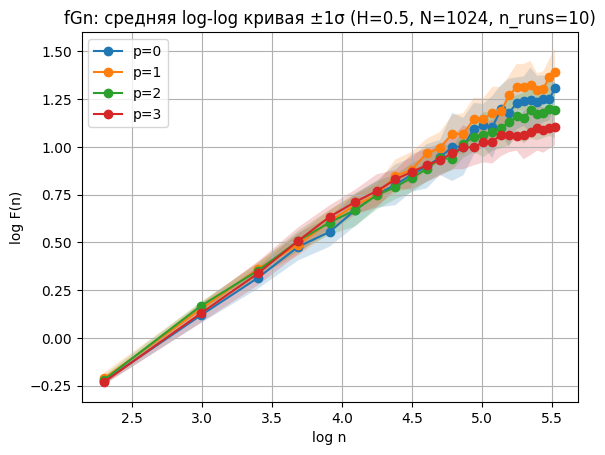

In [10]:
def aggregate_loglog_curves(H: float, N: int, rtype: str, ps=(0,1,2,3), n_runs: int = 10, seed: int = 7):
    rng = np.random.default_rng(seed)
    step = max(10, (N//4)//60)
    scales = np.arange(10, N//4, step)
    logn = np.log(scales)

    plt.figure()
    for p in ps:
        logs = []
        for _ in range(n_runs):
            fgn = fgn_spectral(H, N, rng=rng)
            sig = fgn if rtype == "fGn" else fbm_from_fgn(fgn)
            integrate = True if rtype == "fGn" else False

            F, s = svd_dfa(sig, s=scales, integrate=integrate, p=p, m=1, L=None, n_min=10, n_max=N//4)
            logs.append(np.log(F))

        logs = np.vstack(logs)
        mu = logs.mean(axis=0)
        sd = logs.std(axis=0, ddof=1) if n_runs > 1 else np.zeros_like(mu)

        plt.plot(logn, mu, marker="o", linestyle="-", label=f"p={p}")
        plt.fill_between(logn, mu - sd, mu + sd, alpha=0.2)

    plt.xlabel("log n")
    plt.ylabel("log F(n)")
    plt.title(f"{rtype}: средняя log-log кривая ±1σ (H={H}, N={N}, n_runs={n_runs})")
    plt.grid(True)
    plt.legend()
    plt.show()

aggregate_loglog_curves(H=0.5, N=2**10, rtype="fGn", n_runs=10, seed=1234)

## Мини‑проверки здравого смысла

In [11]:
def sanity_monotonicity_demo(N=2**10, n_runs=10, seed=0):
    rng = np.random.default_rng(seed)
    scales = np.array([2**i for i in range(3, 20)])

    means = []
    for H in Hs:
        est = []
        for _ in range(n_runs):
            fgn = fgn_spectral(H, N, rng=rng)
            F, s = svd_dfa(fgn, s=scales, integrate=True, p=2, m=1)
            est.append(estimate_hurst_from_loglog(F, s))
        means.append((H, float(np.mean(est))))

    print("Monotonicity (fGn, integrate=True, p=2):")
    for H, m in means:
        print(f"  H={H:.1f} -> mean(Ĥ)={m:.3f}")
    return means

_ = sanity_monotonicity_demo()

Monotonicity (fGn, integrate=True, p=2):
  H=0.1 -> mean(Ĥ)=0.172
  H=0.2 -> mean(Ĥ)=0.227
  H=0.4 -> mean(Ĥ)=0.379
  H=1.0 -> mean(Ĥ)=0.895
  H=1.2 -> mean(Ĥ)=1.088
